In [92]:
import unittest
import numpy as np
import torch
import sys, os
import mmcv
from bevdepth.datasets.nusc_det_dataset import NuscDetDataset
from bevdepth.datasets.data_utils import depthImg2scatter
import matplotlib.pyplot as plt
import open3d as o3d
from matplotlib.colors import LinearSegmentedColormap
%config InlineBackend.figure_format = 'svg'


In [93]:
CLASSES = [
    'car',
    'truck',
    'construction_vehicle',
    'bus',
    'trailer',
    'barrier',
    'motorcycle',
    'bicycle',
    'pedestrian',
    'traffic_cone',
]
H = 900
W = 1600
final_dim = (256, 704)
img_conf = dict(img_mean=[123.675, 116.28, 103.53],
                img_std=[58.395, 57.12, 57.375],
                to_rgb=True)
ida_aug_conf = {
    'resize_lim': (0.4, 0.4),
    'final_dim':
    final_dim,
    'rot_lim': (0, 0),
    'H':
    H,
    'W':
    W,
    'rand_flip':
    True,
    'bot_pct_lim': (0.0, 0.0),
    'cams': [
        'CAM_FRONT_LEFT', 'CAM_FRONT', 'CAM_FRONT_RIGHT', 'CAM_BACK_LEFT',
        'CAM_BACK', 'CAM_BACK_RIGHT'
    ],
    'Ncams':
    6,
}

bda_aug_conf = {
    'rot_lim': (0, 0),
    'scale_lim': (1, 1),
    'flip_dx_ratio': 0,
    'flip_dy_ratio': 0
}


class TestNuscMVDetData(unittest.TestCase):

    def test_voxel_pooling(self):
        np.random.seed(0)
        torch.random.manual_seed(0)
        nusc = NuscDetDataset(ida_aug_conf,
                              bda_aug_conf,
                              CLASSES,
                              './test/data/nuscenes',
                              './test/data/nuscenes/infos.pkl',
                              True,
                              sweep_idxes=[4])
        ret_list = nusc[0]
        assert torch.isclose(ret_list[0].mean(),
                             torch.tensor(-0.4667),
                             rtol=1e-3)
        assert torch.isclose(ret_list[1].mean(),
                             torch.tensor(0.1678),
                             rtol=1e-3)
        assert torch.isclose(ret_list[2].mean(),
                             torch.tensor(230.0464),
                             rtol=1e-3)
        assert torch.isclose(ret_list[3].mean(),
                             torch.tensor(8.3250),
                             rtol=1e-3)
        assert torch.isclose(ret_list[4].mean(), torch.tensor(0.25), rtol=1e-3)
        assert torch.isclose(ret_list[5].mean(), torch.tensor(0.25), rtol=1e-3)


In [94]:
nusc = NuscDetDataset(ida_aug_conf,
                              bda_aug_conf,
                              CLASSES,
                              './data/nuScenes',
                              './data/nuScenes/nuscenes_infos_train.pkl',
                              True,
                              sweep_idxes=[4], return_depth=True)


(-0.5, 703.5, 255.5, -0.5)

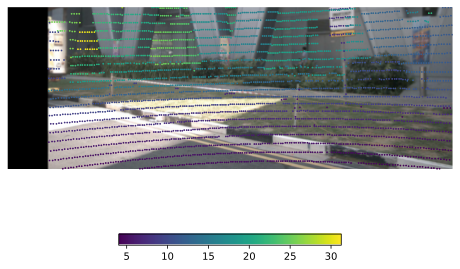

In [95]:
ret_list = nusc.check(0)

for i in range(ida_aug_conf['Ncams']):
    img = ret_list[0][0, 0, :,:,:]
    img = img.permute(1, 2, 0)

    # 归一化到0-1的范围
    img = img / 255.0

    # 将Tensor转换为numpy数组
    img_np = img.numpy()

    plt.figure(figsize=(8, 8))  # 设置图像大小，单位为英寸
    plt.imshow(img_np)




    dep = ret_list[-1][0, 0, :, :]

    point_set = depthImg2scatter(dep.numpy())
    plt.scatter(point_set[1], point_set[0], c=point_set[2], s=0.7)
    plt.colorbar(orientation='horizontal', shrink=0.5) # 横着放置并缩小为原来的0.5倍
    plt.axis('off')
    plt.show()
